In [2]:
# Loading data
import pandas as pd
data = pd.read_csv('./ml-latest-small/ratings.csv')

In [4]:
# Exploratory data analysis
data.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [5]:
data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
data.shape

(100836, 4)

In [151]:
data['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [109]:
# are User Ids continuous
all_users = set(data['userId'])
len(all_users), min(all_users), max(all_users), len(all_users) == max(all_users)

(610, 1, 610, True)

In [110]:
# are Movie Ids continuous
all_movies = set(data['movieId'])
len(all_movies), min(all_movies), max(all_movies), len(all_movies) == max(all_movies)

(9724, 1, 193609, False)

In [7]:
# Check how many different rating scores
rating_set = set(data['rating'])
len(rating_set), rating_set

(10, {0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0})

In [8]:
#from apyori import apriori
#rules = apriori(trans, min_support = 0.1, min_confidence = 0.5, min_lift = 1.1, min_length = 2)
#results = list(rules)

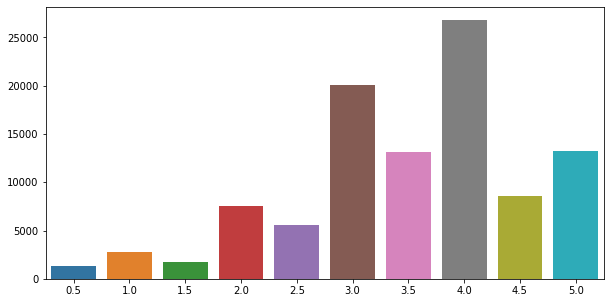

In [21]:
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
ratingFreq = nltk.FreqDist(data['rating'])
ratingFreq = pd.Series(dict(ratingFreq))
fig, ax = plt.subplots(figsize=(10,5))
all_plot = sns.barplot(x=ratingFreq.index, y=ratingFreq.values, ax=ax)


In [159]:
moviesDF = pd.read_csv('./ml-latest-small/movies.csv')
moviesDF.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [164]:
# Assume rating score less than 3 mean does not like, don't recommend others to watch
# We should remove these from the 'transactions'
# E.g. movie 8 and 9 always be watched by same person, this don't mean if new customer who watched movie 8
# our system would recommend movie 9 to him (because, movie 9 got lower rating means they watched but they don't like it)
# build 'transactions lists - user = customer, movie = item'
user_movies_dict = {}
movie_users_dict = {}
user_movies_dict_full = {}
for idx in range(data.shape[0]):
    if user_movies_dict_full.get(data['userId'][idx]) is None:
        user_movies_dict_full[data['userId'][idx]] = set()
    user_movies_dict_full[data['userId'][idx]].add(data['movieId'][idx])
    if data['rating'][idx] > 3:
        if user_movies_dict.get(data['userId'][idx]) is None:
            user_movies_dict[data['userId'][idx]] = []
        if movie_users_dict.get(data['movieId'][idx]) is None:
            movie_users_dict[data['movieId'][idx]] = []
        user_movies_dict[data['userId'][idx]].append(data['movieId'][idx])
        movie_users_dict[data['movieId'][idx]].append(data['userId'][idx])

In [165]:
# function to calculate candidates frequent table for a movie
def get_candidates_for_movie(movieX):
    users = movie_users_dict.get(movieX)
    movies = []
    for user in users:
        movies.extend(user_movies_dict.get(user))
    return nltk.FreqDist(movies)

In [166]:

candsFreqForMovieA

FreqDist({1: 165, 356: 101, 318: 98, 260: 95, 296: 87, 2571: 86, 480: 82, 593: 80, 1196: 79, 1198: 78, ...})

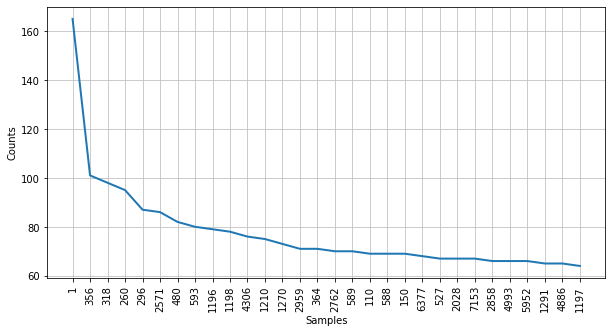

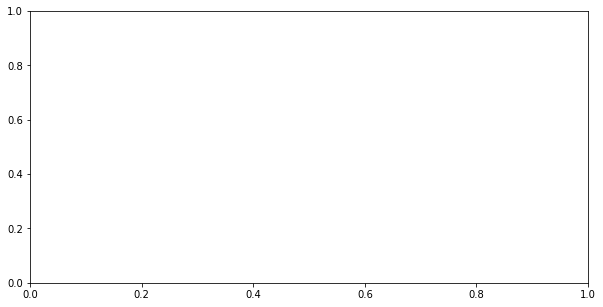

In [175]:
movieA = 1
candsFreqForMovieA = get_candidates_for_movie(movieA)
plt.subplots(figsize=(10,5))
ax.set_xlabel('movieId')
ax = candsFreqForMovieA.plot(30)
plt.subplots(figsize=(10,5))
ax.set_xlabel('movieId')
plt.show()

In [55]:
# function to get latest n favorite movies for user
def get_latest_n_movies_for_user(userA, n):
    sub = data[(data['userId'] == userA) & (data['rating'] > 3)]
    sub = sub.sort_values(by='timestamp', ascending=False)
    return list(sub.head(n)['movieId'])

In [56]:
sub = get_latest_n_movies_for_user(1, 20)
sub

[2492,
 2012,
 2478,
 553,
 157,
 3053,
 1298,
 3448,
 151,
 1090,
 1224,
 5060,
 527,
 3147,
 2353,
 47,
 593,
 3033,
 1206,
 3702]

In [93]:
# define function to find recommendations for user
def get_candidate_for_user(userA):
    latestMovies = get_latest_n_movies_for_user(userA, 20)
    candidates = dict()
    for movie in latestMovies:
        freq = dict(get_candidates_for_movie(movie))
        for key, value in freq.items():
            if key in user_movies_dict_full.get(userA):
                continue
            if candidates.get(key) is None:
                candidates[key] = 0
            candidates[key] += value
    return dict(sorted(candidates.items(), key=lambda x: x[1], reverse=True))


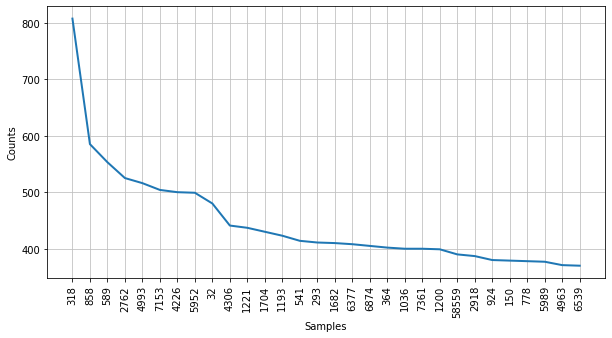

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [95]:
user1 = 1
candi = get_candidate_for_user(user1)
candFreq = nltk.FreqDist(candi)
plt.subplots(figsize=(10,5))
candFreq.plot(30)

In [85]:
candFreq = nltk.FreqDist()
for x in candi:
    candFreq[x[0]] += x[1]

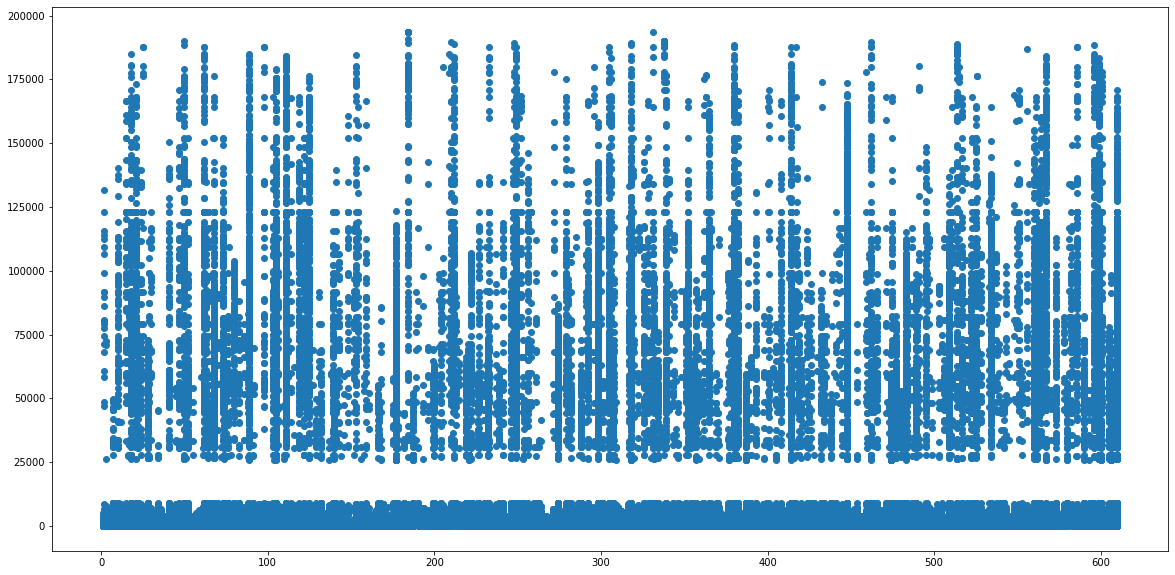

In [98]:
# scatter plot userId, movieId
plt.subplots(figsize=(20,10))
plt.scatter(data['userId'], data['movieId'])

In [107]:
len(all_movies), min(all_movies), max(all_movies)

(9724, 1, 193609)

In [115]:
movie_users_dist_dict = {}
for idx in range(data.shape[0]):
    if data['rating'][idx] > 3:
        if movie_users_dist_dict.get(data['movieId'][idx]) is None:
            movie_users_dist_dict[data['movieId'][idx]] = dict()
        movie_users_dist_dict[data['movieId'][idx]][data['userId'][idx]] = data['rating'][idx]

In [123]:
# calculate two movie's distance
def dist_between_movies(movieARating, movieBRating):
    comm = 0
    if len(movieARating) < len(movieBRating):
        tmp = movieARating
        movieARating = movieBRating
        movieBRating = tmp
    for k, v in movieARating.items():
        v2 = movieBRating.get(k, 10 + v)
        comm += (1 - abs(v2 - v)/10)
    return (len(movieARating) - comm)/len(movieARating)

In [125]:
movieB = movie_users_dist_dict.get(2)
dist = dist_between_movies(movieB, movieA)
dist

0.8193939393939395

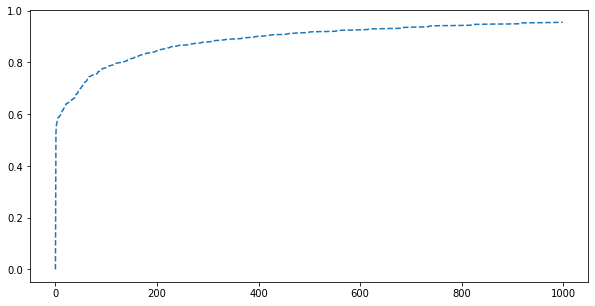

In [156]:
# calculate distances between movie 1 and other movies 
dists_to_movie_1 = {}
movie1Rating = movie_users_dist_dict.get(1)
for movie, ratings in movie_users_dist_dict.items():
    dists_to_movie_1[movie] = dist_between_movies(movie1Rating, ratings)

# plot first 1000 nearst dist
dists = list(dists_to_movie_1.values())
dists.sort()
plt.subplots(figsize=(10,5))
plt.plot(dists[:1000], ls = '--')

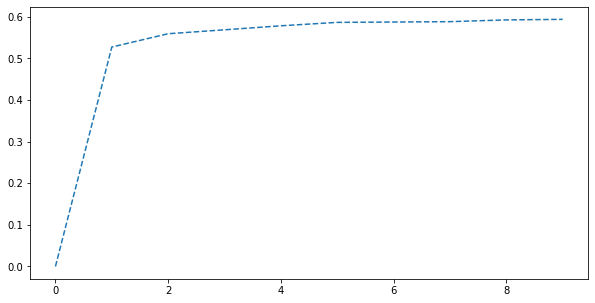

In [158]:
# Zoom In first 10 nearest distances
plt.subplots(figsize=(10,5))
plt.plot(dists[:10], ls = '--')

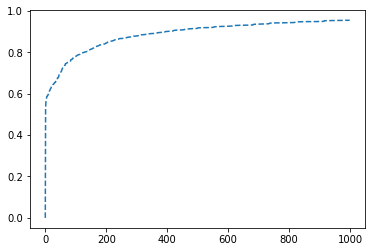

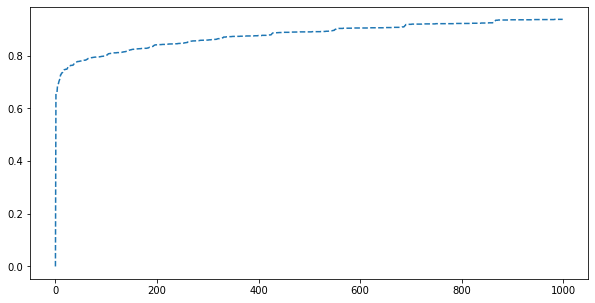

In [155]:
# calculate distances between movie 2 and other movies 
dists_to_movie_2 = {}
movie1Rating = movie_users_dist_dict.get(2)
for movie, ratings in movie_users_dist_dict.items():
    dists_to_movie_2[movie] = dist_between_movies(movie1Rating, ratings)
    #print(dists_to_movie_1[movie])
dists = list(dists_to_movie_2.values())
dists.sort()
plt.subplots(figsize=(10,5))
plt.plot(dists[:1000], ls = '--')

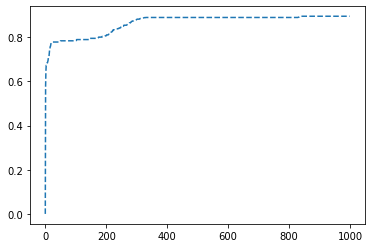